In [13]:
######pip install vit-pytorch linformer



In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
import torch   
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms   
from torch.optim.lr_scheduler import StepLR   
from torch.utils.data import DataLoader, Dataset

In [3]:
from linformer import Linformer   
import glob   
from PIL import Image
from itertools import chain   
from vit_pytorch.efficient import ViT   
from tqdm.notebook import tqdm   
#from __future__ import print_function

In [4]:
import glob  

In [7]:
train_dir = '/Users/Hutch/Desktop/allbut10cdz'
test_dir = '/Users/Hutch/Desktop/back10cdz'

In [8]:
#Creating train and test list 

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

#printing length of the dataset

print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 495
Test Data: 32


In [9]:
from sklearn.model_selection import train_test_split  

In [10]:
batch_size = 64
epochs = 25           #EPICS
lr = 3e-5
gamma = 0.7 #for learning rate scheduler 

In [11]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

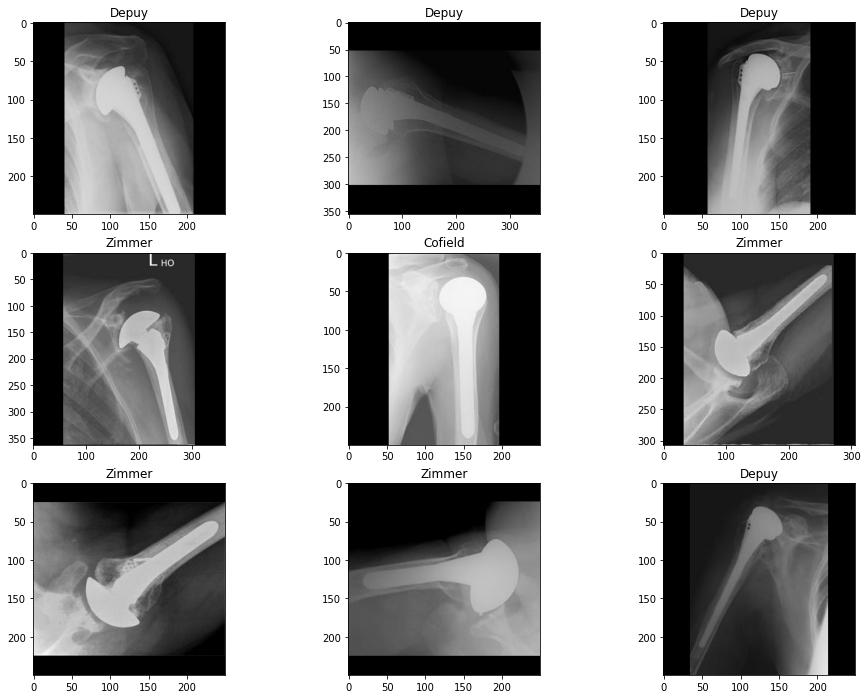

In [12]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [13]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=1014)
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 396
Validation Data: 99
Test Data: 32


In [14]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

In [15]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "Zimmer" else 0
        return img_transformed, label

In [16]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [17]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [18]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [22]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=3,                   #classes
    transformer=efficient_transformer,
    channels=3,
).to(device)

In [23]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)


In [24]:

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


Epoch : 1 - loss : 0.7844 - acc: 0.7329 - val_loss : 0.6879 - val_acc: 0.6984




Epoch : 2 - loss : 0.6320 - acc: 0.7232 - val_loss : 0.6052 - val_acc: 0.7308




Epoch : 3 - loss : 0.6159 - acc: 0.7135 - val_loss : 0.5869 - val_acc: 0.7373




Epoch : 4 - loss : 0.5922 - acc: 0.7329 - val_loss : 0.5900 - val_acc: 0.7308




Epoch : 5 - loss : 0.5694 - acc: 0.7522 - val_loss : 0.5880 - val_acc: 0.7308




Epoch : 6 - loss : 0.5743 - acc: 0.7426 - val_loss : 0.5960 - val_acc: 0.7243




Epoch : 7 - loss : 0.5783 - acc: 0.7426 - val_loss : 0.5873 - val_acc: 0.7308




Epoch : 8 - loss : 0.5773 - acc: 0.7426 - val_loss : 0.6120 - val_acc: 0.7049




Epoch : 9 - loss : 0.5976 - acc: 0.7232 - val_loss : 0.5786 - val_acc: 0.7373




Epoch : 10 - loss : 0.6099 - acc: 0.7039 - val_loss : 0.6004 - val_acc: 0.7179




Epoch : 11 - loss : 0.5806 - acc: 0.7426 - val_loss : 0.5879 - val_acc: 0.7308




Epoch : 12 - loss : 0.5990 - acc: 0.7232 - val_loss : 0.6046 - val_acc: 0.7179




Epoch : 13 - loss : 0.6043 - acc: 0.7135 - val_loss : 0.5903 - val_acc: 0.7308




Epoch : 14 - loss : 0.6194 - acc: 0.6942 - val_loss : 0.5901 - val_acc: 0.7308




Epoch : 15 - loss : 0.6084 - acc: 0.7039 - val_loss : 0.5906 - val_acc: 0.7243




Epoch : 16 - loss : 0.6055 - acc: 0.7135 - val_loss : 0.5707 - val_acc: 0.7437




Epoch : 17 - loss : 0.5996 - acc: 0.7135 - val_loss : 0.5869 - val_acc: 0.7308




Epoch : 18 - loss : 0.5914 - acc: 0.7232 - val_loss : 0.5991 - val_acc: 0.7179




Epoch : 19 - loss : 0.6208 - acc: 0.6942 - val_loss : 0.5764 - val_acc: 0.7373




Epoch : 20 - loss : 0.5913 - acc: 0.7232 - val_loss : 0.6019 - val_acc: 0.7179




Epoch : 21 - loss : 0.5879 - acc: 0.7232 - val_loss : 0.5894 - val_acc: 0.7243




Epoch : 22 - loss : 0.5988 - acc: 0.7135 - val_loss : 0.5699 - val_acc: 0.7373




Epoch : 23 - loss : 0.5820 - acc: 0.7329 - val_loss : 0.6008 - val_acc: 0.7179




Epoch : 24 - loss : 0.5857 - acc: 0.7232 - val_loss : 0.5942 - val_acc: 0.7243




Epoch : 25 - loss : 0.5880 - acc: 0.7329 - val_loss : 0.5887 - val_acc: 0.7308



https://analyticsindiamag.com/hands-on-vision-transformers-with-pytorch/

https://analyticsindiamag.com/hands-on-vision-transformers-with-pytorch/

https://ai.googleblog.com/2020/12/transformers-for-image-recognition-at.html

https://github.com/google-research/vision_transformer